In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from PIL import Image

### MNIST Data Exploration

In [2]:
dataset = datasets.MNIST(root='../data', train=True, download=True)
sampler = utils.data.RandomSampler(dataset)

In [3]:
dataset[next(sampler.__iter__())][0].show()

## Creating Training and Test Set

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [5]:
default_batch_size = 32
loader_args = {'batch_size' : default_batch_size, 'shuffle' : True}
if use_cuda:
    loader_args.update({'pin_memory' : True, 'num_workers' : 1})

In [6]:
trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transforms.ToTensor())
train_loader = utils.data.DataLoader(trainset, **loader_args)
testset  = datasets.MNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())
test_loader = utils.data.DataLoader(testset, **loader_args)

In [7]:
image_size = trainset[0][0].size()
image_size

torch.Size([1, 28, 28])

In [8]:
label_size = 10

### Convolution Model

In [9]:
class MNISTClassifier(nn.Module):
    def __init__(self, isize, osize):
        super(MNISTClassifier, self).__init__()
        fc1_isize = int((((isize - 2 - 2) / 2) ** 2) * 32)
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(fc1_isize, 128)
        self.fc2 = nn.Linear(128, osize)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [10]:
model_file = '../models/mnist_classifier.pt'
model = MNISTClassifier(28, 10)

In [ ]:
#load model if it already exists
model.load(model_file)

In [11]:
model = model.to(device)

### Training

In [12]:
from abc import ABC, abstractmethod

class StatsCollector(ABC):
    @abstractmethod
    def train_gather(self, epoch, batch_idx, batch_size, dataset_size, loss):
        pass
    @abstractmethod
    def eval_gather(self, train_epoch, loss, accuracy):
        pass
    @abstractmethod
    def eval_pred_gather(self, train_epoch, predictions, targets):
        pass
    @abstractmethod
    def train_reset(self):
        pass
    @abstractmethod
    def eval_reset(self):
        pass

class FrequentLossCollector(StatsCollector):
    def __init__(self, frequency, report_frequency = 0, eval_report_frequency = 0):
        self.frequency = frequency
        self.report_frequency = report_frequency
        self.eval_report_frequency = eval_report_frequency
        self.losses = []
        self.eval_losses = []
        self.eval_predictions_targets = []
    def train_gather(self, epoch, batch_idx, batch_size, dataset_size, loss):
        if (epoch * (dataset_size / batch_size) + batch_idx) % self.frequency == 0:
            self.losses.append((epoch, batch_idx, batch_size, dataset_size, loss))
        if report_frequency > 0 and (epoch * (dataset_size / batch_size) + batch_idx) % self.report_frequency == 0:
            print("Epoch {}, {}/{}: {}".format(epoch, batch_idx * batch_size, dataset_size, loss))
    def eval_gather(self, train_epoch, loss, accuracy):
        self.eval_losses.append((train_epoch, loss, accuracy))
        if self.eval_report_frequency > 0 and train_epoch % self.eval_report_frequency == 0:
            print("Epoch {}: loss {} accuracy {}".format(train_epoch, loss, accuracy))
    def eval_pred_gather(self, train_epoch, predictions, targets):
        self.eval_predictions_targets.append((train_epoch, predictions, targets))
    def train_reset(self):
        self.losses = []
    def eval_reset(self):
        self.eval_losses = []
        self.eval_predictions_targets = []

class EpochLossCollector(StatsCollector):
    def __init__(self, frequency, report_frequency = 0, eval_report_frequency = 0):
        self.frequency = frequency
        self.report_frequency = report_frequency
        self.eval_report_frequency = eval_report_frequency
        self.losses = []
        self.eval_losses = []
        self.eval_predictions_targets = []
    def train_gather(self, epoch, batch_idx, batch_size, dataset_size, loss):
        if epoch % self.frequency == 0 and (batch_idx + 1) * batch_size == dataset_size:
            self.losses.append((epoch, loss))
        if self.report_frequency > 0 and epoch % self.report_frequency == 0 and (batch_idx + 1) * batch_size == dataset_size:
            print("Epoch {}, {}/{}: {}".format(epoch, batch_idx * batch_size, dataset_size, loss))
    def eval_gather(self, train_epoch, loss, accuracy):
        self.eval_losses.append((train_epoch, loss, accuracy))
        if self.eval_report_frequency > 0 and train_epoch % self.eval_report_frequency == 0:
            print("Epoch {}: loss {} accuracy {}".format(train_epoch, loss, accuracy))
    def eval_pred_gather(self, train_epoch, predictions, targets):
        self.eval_predictions_targets.append((train_epoch, predictions, targets))
    def train_reset(self):
        self.losses = []
    def eval_reset(self):
        self.eval_losses = []
        self.eval_predictions_targets = []

In [13]:
def train(model, device, loader, optimizer, loss, epoch, collector):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        l = loss(output, target)
        l.backward()
        optimizer.step()
        collector.train_gather(epoch, batch_idx, len(data), len(loader.dataset), l.item())

In [14]:
def validate(model, device, loader, loss, train_epoch, collector):
    model.eval()
    total_loss = 0.
    total_corrects = 0.
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            collector.eval_pred_gather(train_epoch, pred, target)
            corrects = pred.eq(target.view_as(pred)).sum().item()
            total_corrects += corrects
    total_loss /= len(loader.dataset)
    accuracy = total_corrects / len(loader.dataset)
    collector.eval_gather(train_epoch, total_loss, accuracy)

In [15]:
def train_validate(model, device, train_loader, test_loader, optimizer, loss, collector, total_epoch):
    for epoch in range(total_epoch):
        train(model, device, train_loader, optimizer, loss, epoch, collector)
        validate(model, device, test_loader, loss, epoch, collector)

In [16]:
learning_rate = 0.0001
total_epochs =5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.NLLLoss()
collector = EpochLossCollector(1, 1)

In [17]:
train_validate(model, device, train_loader, test_loader, optimizer, loss, collector, total_epochs)

Epoch 0, 59968/60000: 0.16705448925495148
Epoch 1, 59968/60000: 0.26304492354393005
Epoch 2, 59968/60000: 0.008326868526637554
Epoch 3, 59968/60000: 0.04203057289123535
Epoch 4, 59968/60000: 0.04412397742271423


### Losses v.r.t. epoch plots

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
train_loss   = np.array([loss for (epoch, loss) in collector.losses])
train_epochs = np.array([epoch for (epoch, loss) in collector.losses])

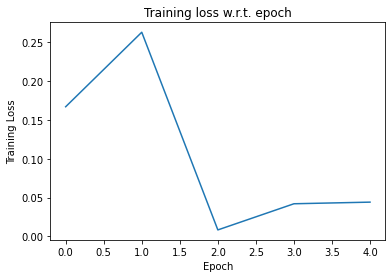

In [20]:
plt.plot(train_epochs, train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training loss w.r.t. epoch')
plt.show()

In [21]:
test_loss  = np.array([loss for (epoch, loss, accuracy) in collector.eval_losses])
test_epoch = np.array([epoch for (epoch, loss, accuracy) in collector.eval_losses])
accuracy   = np.array([accuracy for (epoch, loss, accuracy) in collector.eval_losses])

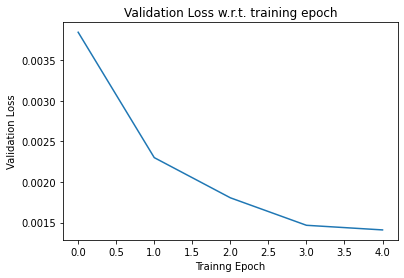

In [22]:
plt.plot(test_epoch, test_loss)
plt.xlabel('Trainng Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss w.r.t. training epoch')
plt.show()

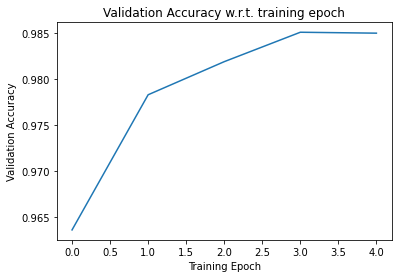

In [23]:
plt.plot(test_epoch, accuracy)
plt.xlabel('Training Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy w.r.t. training epoch')
plt.show()

### Test

In [24]:
import random

In [25]:
test_idx = random.randint(0, len(testset) - 1)

In [26]:
test_sample = testset[test_idx][0]
test_sample = test_sample.unsqueeze_(0)
test_sample = test_sample.to(device)
test_prediction = model(test_sample)
test_prediction.argmax(dim=1)

tensor([1], device='cuda:0')

In [27]:
testset[test_idx][1]

1

### Saving Model

In [28]:
torch.save(model, model_file)